# Lokale OCR-Pipeline: Tesseract + Calamari (Fraktur)

Dieses Notebook führt OCR auf `testbild.png` aus – einmal mit Tesseract, einmal mit Calamari.

In [15]:
from pathlib import Path
import subprocess
import shutil
from PIL import Image
import pytesseract
from pytesseract import Output

# Funktioniert sowohl aus dem Repo-Root als auch aus ./notebooks.
CANDIDATE_ROOTS = [Path.cwd().resolve(), Path.cwd().resolve().parent]
PROJECT_ROOT = next((p for p in CANDIDATE_ROOTS if (p / 'Abl_1900_X__S__0287.tif').exists()), CANDIDATE_ROOTS[0])
TEST_IMAGE = PROJECT_ROOT / 'Abl_1900_X__S__0287.tif'
INPUT_STEM = TEST_IMAGE.stem  # Dateiname ohne Extension für Output-Ordner
VENV311_BIN = PROJECT_ROOT / '.venv311' / 'bin'
CALAMARI_PREDICT_BIN = VENV311_BIN / 'calamari-predict'
CALAMARI_PREDICT_EXE = str(CALAMARI_PREDICT_BIN) if CALAMARI_PREDICT_BIN.exists() else 'calamari-predict'
OUT_DIR = PROJECT_ROOT / 'outputs'
OUT_DIR.mkdir(exist_ok=True)

assert TEST_IMAGE.exists(), f'Missing test image: {TEST_IMAGE}'

print('Using image:', TEST_IMAGE)
print('Input stem:', INPUT_STEM)
print('Outputs:', OUT_DIR)
print('tesseract:', shutil.which('tesseract'))
print('calamari-predict (resolved):', CALAMARI_PREDICT_EXE)
print('calamari-predict (PATH):', shutil.which('calamari-predict'))

Using image: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/Abl_1900_X__S__0287.tif
Input stem: Abl_1900_X__S__0287
Outputs: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs
tesseract: /opt/homebrew/bin/tesseract
calamari-predict (resolved): /Users/stazh/Documents/GithubRepos_stazh/ocr_2/.venv311/bin/calamari-predict
calamari-predict (PATH): /Users/stazh/Documents/GithubRepos_stazh/ocr_2/.venv311/bin/calamari-predict


## (Optional) Bildvorschau

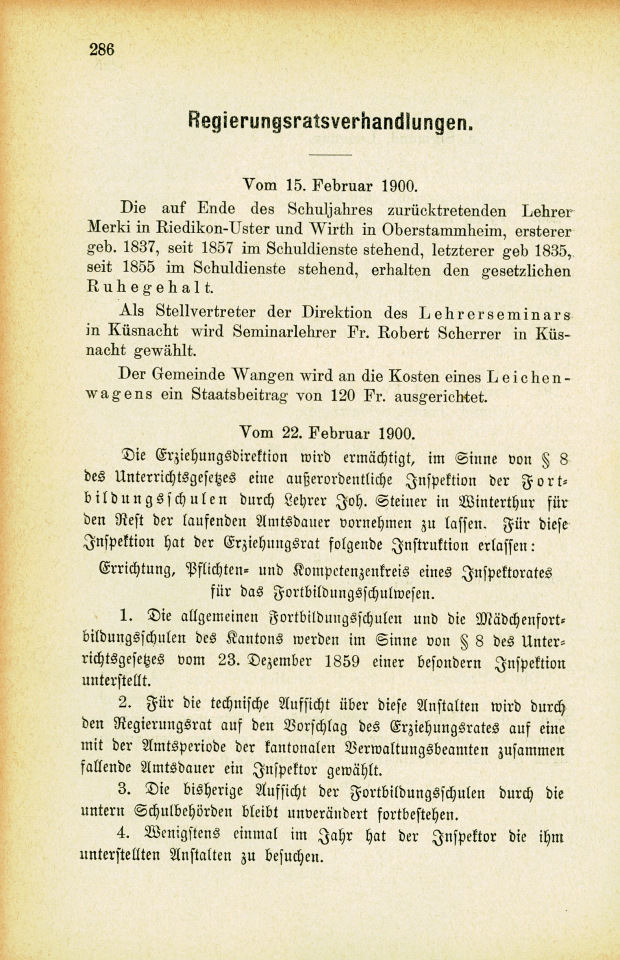

In [16]:
img = Image.open(TEST_IMAGE)
img


## 1) Tesseract-OCR

In [17]:
# Tesseract-Sprachen anpassen, z. B. 'deu', 'frk', oder kombiniert: 'deu+frk'
TESS_LANG = 'deu+frk'
TESS_PSM = 6  # 6 = assume a uniform block of text
TESS_MODEL_NAME = f'tesseract_{TESS_LANG}'.replace('+', '-')

tess_config = f'--psm {TESS_PSM}'
tess_text = pytesseract.image_to_string(img, lang=TESS_LANG, config=tess_config)

# Output-Ordner: modellname_inputfilename
tess_out_dir = OUT_DIR / f'{TESS_MODEL_NAME}_{INPUT_STEM}'
tess_out_dir.mkdir(exist_ok=True)
tess_out = tess_out_dir / 'ocr_output.txt'
tess_out.write_text(tess_text, encoding='utf-8')

print(tess_text[:2000])
print('Saved:', tess_out)

3 286
| Regierungsratsverhandlungen.
Vom 15. Februar 1900.

Die auf Ende des Schuljahres zurücktretenden Lehrer
Merki in Riedikon-Uster und Wirth in Oberstammheim, ersterer
geb. 1837, seit 1857 im Schuldienste stehend, letzterer geb 1835,
seit 1855 im Schuldienste stehend, erhalten den gesetzlichen
Ruhegehalt.

Als Stellvertreter der Direktion des Lehrerseminars

4 in Küsnacht wird Seminarlehrer Fr. Robert Scherrer in Küs-
nacht gewählt.

Der Gemeinde Wangen wird an die Kosten eines Leichen-
wagens ein Staatsbeitrag von 120 Fr. ausgerichtet.

5 Vom 22. Februar 1900.

Die Erziefungsdireftion wird ermächtigt, im Sinne von $ 8
des Unterrichtsgefeßes eine außerordentliche Inſpektion der Fort-
bildungsſchulen durch Lehrer Joh. Steiner in Winterthur für
den Reſt der laufenden Amtsdauer vornehmen zu laſſen. Für dieſe

4 Inſpektion hat der Erziehungsrat folgende Juſtruftion erlaſſen :
Errichtung, Pflichten- und Kompetenzenkreis eines Juſpektorates
3 für das Fortbildungsſchulweſen.

1. Die allg

## 2) Zeilensegmentierung (für Calamari)

Das Fraktur-Modell arbeitet besser auf **Zeilenbildern**. Wir nutzen Tesseract nur für die Layout-/Zeilen-Segmentierung.

## 2a) Bildvorverarbeitung (Binarisierung)

Calamari-Modelle wurden auf binarisierten Bildern (OCRopus nlbin) trainiert. Eine einfache Otsu-Binarisierung verbessert die Ergebnisse.

Original shape: (960, 620), Binary shape: (960, 620)


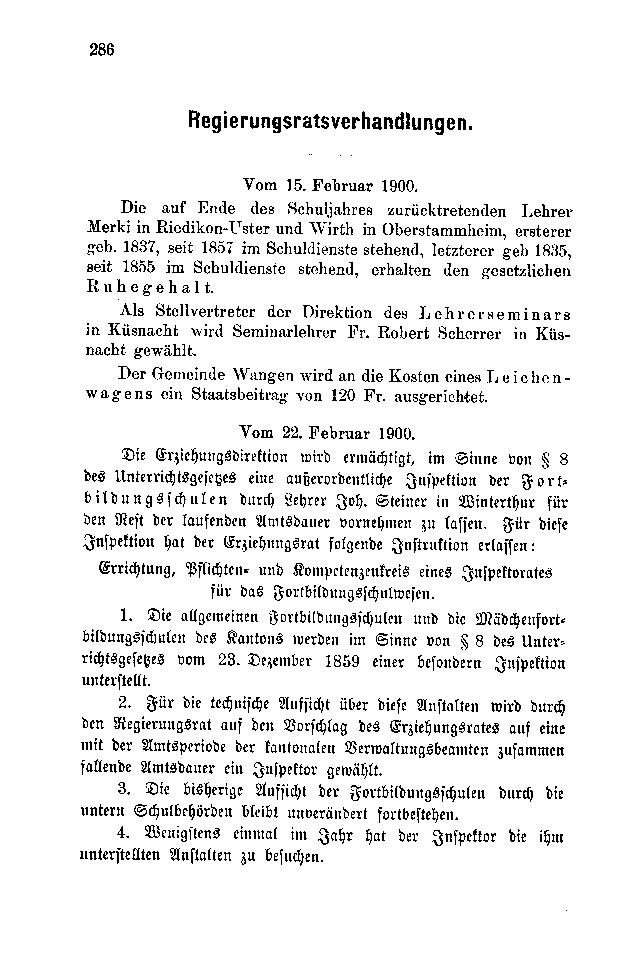

In [18]:
import cv2
import numpy as np

# Bild laden und Binarisierung durchführen
img_cv = cv2.imread(str(TEST_IMAGE), cv2.IMREAD_GRAYSCALE)

# Otsu-Binarisierung (gut für historische Drucke)
_, img_binary = cv2.threshold(img_cv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Als PIL Image für weitere Verarbeitung
img_bin_pil = Image.fromarray(img_binary)

# Vorschau
print(f'Original shape: {img_cv.shape}, Binary shape: {img_binary.shape}')
img_bin_pil

In [19]:
# Lines-Ordner im Input-spezifischen Unterordner
lines_dir = OUT_DIR / f'lines_{INPUT_STEM}'
lines_dir.mkdir(exist_ok=True)

# Verwende binarisiertes Bild für bessere Segmentierung und OCR
data = pytesseract.image_to_data(
    img_bin_pil,  # Binarisiertes Bild
    lang=TESS_LANG,
    config=tess_config,
    output_type=Output.DICT,
)

line_records = []
n = len(data['level'])
for i in range(n):
    # level==4 entspricht 'line' in der Tesseract-TSV-Hierarchie.
    if data['level'][i] != 4:
        continue
    x = data['left'][i]
    y = data['top'][i]
    w = data['width'][i]
    h = data['height'][i]
    if w <= 0 or h <= 0:
        continue
    line_id = (data['block_num'][i], data['par_num'][i], data['line_num'][i])
    line_records.append((line_id, x, y, w, h))

line_records.sort(key=lambda r: r[0])

line_image_paths = []
for idx, (_, x, y, w, h) in enumerate(line_records):
    crop = img_bin_pil.crop((x, y, x + w, y + h))  # Binarisiertes Bild
    line_path = lines_dir / f'line_{idx:03d}.png'
    crop.save(line_path)
    line_image_paths.append(line_path)

print(f'Extracted {len(line_image_paths)} binarized line images to {lines_dir}')
line_image_paths[:5]

Extracted 33 binarized line images to /Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287


[PosixPath('/Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287/line_000.png'),
 PosixPath('/Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287/line_001.png'),
 PosixPath('/Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287/line_002.png'),
 PosixPath('/Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287/line_003.png'),
 PosixPath('/Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/lines_Abl_1900_X__S__0287/line_004.png')]

## 3) Calamari-OCR (Frakturmodell, zeilenweise)

Calamari wird hier über die CLI aufgerufen und auf die segmentierten Zeilenbilder angewendet.

In [ ]:
# Das deep3_lsh4 Modell (Latin Script Historical) ist das beste für gemischte Fraktur/Antiqua
# Alternative: gt4histocr (bereits vorhanden)
MODEL_DIR = (PROJECT_ROOT / 'models/calamari_models/calamari_models_experimental/deep3_fraktur19').resolve()
CALAMARI_MODEL_NAME = MODEL_DIR.name  # z.B. 'deep3_lsh4'
CALAMARI_MODEL_PATHS = [
    MODEL_DIR / '0.ckpt.json',
    MODEL_DIR / '1.ckpt.json',
    MODEL_DIR / '2.ckpt.json',
    MODEL_DIR / '3.ckpt.json',
    MODEL_DIR / '4.ckpt.json',
]

print(f'Model: {CALAMARI_MODEL_NAME}')
for p in CALAMARI_MODEL_PATHS:
    print(p, 'exists:', p.exists())

Model: deep3_antiqua-hist
/Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/0.ckpt.json exists: True
/Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/1.ckpt.json exists: True
/Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/2.ckpt.json exists: True
/Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/3.ckpt.json exists: True
/Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/4.ckpt.json exists: True


In [21]:
# Output-Ordner: modellname_inputfilename
calamari_out_dir = OUT_DIR / f'{CALAMARI_MODEL_NAME}_{INPUT_STEM}'
calamari_out_dir.mkdir(exist_ok=True)

assert line_image_paths, 'No line images found; run the segmentation cell first.'

import os
env = os.environ.copy()
env['PATH'] = str(VENV311_BIN) + ':' + env.get('PATH', '')

# Use Python + module instead of the script (avoids broken shebang from moved venv)
python_exe = VENV311_BIN / 'python3'
cmd = [
    str(python_exe), '-m', 'calamari_ocr.scripts.predict',
    '--checkpoint', *[str(p) for p in CALAMARI_MODEL_PATHS],
    '--data.images', *[str(p) for p in line_image_paths],
    '--output_dir', str(calamari_out_dir),
]

print(f'Output dir: {calamari_out_dir}')
print('Running:', ' '.join(cmd[:10]), '...')
result = subprocess.run(cmd, capture_output=True, text=True, env=env)
print('Return code:', result.returncode)
print(result.stdout[:2000])
if result.returncode != 0:
    print(result.stderr[:2000])
    raise RuntimeError('calamari-predict failed; see stderr above.')

Output dir: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/deep3_antiqua-hist_Abl_1900_X__S__0287
Running: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/.venv311/bin/python3 -m calamari_ocr.scripts.predict --checkpoint /Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/0.ckpt.json /Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/1.ckpt.json /Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/2.ckpt.json /Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/3.ckpt.json /Users/stazh/Documents/GithubRepos_stazh/ocr_2/models/calamari_models/calamari_models_experimental/deep3_antiqua-hist/4.ckpt.json --data.images ...
Return code: 0



In [22]:
# Calamari schreibt pro Zeile eine <stem>.pred.txt
pred_texts = []
missing = []
for p in line_image_paths:
    pred_path = calamari_out_dir / f'{p.stem}.pred.txt'
    if pred_path.exists():
        pred_texts.append(pred_path.read_text(encoding='utf-8').strip())
    else:
        missing.append(pred_path)

if missing:
    print(f'Missing {len(missing)} prediction files (showing up to 5):')
    for mp in missing[:5]:
        print(' -', mp)

calamari_text = '\n'.join(t for t in pred_texts if t)
calamari_txt_out = calamari_out_dir / 'ocr_output.txt'
calamari_txt_out.write_text(calamari_text, encoding='utf-8')

print(calamari_text[:2000])
print('Saved:', calamari_txt_out)

286
Regierungsratsverhandlungen.
Vom 15. Fobruar 1900.
Die auf Ende des Schuljahres ʒurücktretenden Lehrer
Merki in Ricdikon-Uster und Wirth in Oberstammheim, ersterer
geb. 1837, seit 1857 im Schuldienste stehend, letʒterer geb 1835,
seit 1855 im Schuldienste stohend, erhalten den gesetʒlichen
Ruhegehalt.
Als Stellvertreter der Direktion des Lehrerseminars
in Küsnacht wird Seminarlehrer Fr. Robert Scherrer in Küs-
nacht gewählt.
Der Gemeinde Wangen wird an die Kosten eines Leichen-
wagens ein Staatsbeitrag von 120 Fr. ausgerichtet.
Vom 22. Februar 1900.
Die Gr;iehungsoirettion mirb ermädtigt, im Sinne bon S 8
bes Unterridtsgejeges eine auferorbentlide Suipettion ber Sort-
bilbungSjduJen burd Sebrer goh. Gteiner in Binterthur für
ben Rejt ber laufenben Mmtsbauer vorneſmen 3u laſjeu. gur biefe
Snſpettion bat ber Grʒiehunggrat folgenbe gnſtruftion erſaſſen:
Grridtung. Bilicten- unb Rompetengeufreis eines Suſpeftorates
für bas gortbiſoungsſdulmejen.
1. Die augemeinen Bortbilbungsjduſen unb

## 4) Mini-Vergleich

In [23]:
def preview(label, text, n=400):
    print(f'--- {label} (first {n} chars) ---')
    print(text[:n])
    print()

print(f'Input: {INPUT_STEM}')
print(f'Tesseract Output: {tess_out_dir}')
print(f'Calamari Output: {calamari_out_dir}')
print()
preview(f'Tesseract ({TESS_MODEL_NAME})', tess_text)
preview(f'Calamari ({CALAMARI_MODEL_NAME})', calamari_text)

Input: Abl_1900_X__S__0287
Tesseract Output: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/tesseract_deu-frk_Abl_1900_X__S__0287
Calamari Output: /Users/stazh/Documents/GithubRepos_stazh/ocr_2/outputs/deep3_antiqua-hist_Abl_1900_X__S__0287

--- Tesseract (tesseract_deu-frk) (first 400 chars) ---
3 286
| Regierungsratsverhandlungen.
Vom 15. Februar 1900.

Die auf Ende des Schuljahres zurücktretenden Lehrer
Merki in Riedikon-Uster und Wirth in Oberstammheim, ersterer
geb. 1837, seit 1857 im Schuldienste stehend, letzterer geb 1835,
seit 1855 im Schuldienste stehend, erhalten den gesetzlichen
Ruhegehalt.

Als Stellvertreter der Direktion des Lehrerseminars

4 in Küsnacht wird Seminarlehrer F

--- Calamari (deep3_antiqua-hist) (first 400 chars) ---
286
Regierungsratsverhandlungen.
Vom 15. Fobruar 1900.
Die auf Ende des Schuljahres ʒurücktretenden Lehrer
Merki in Ricdikon-Uster und Wirth in Oberstammheim, ersterer
geb. 1837, seit 1857 im Schuldienste stehend, letʒterer geb 1835,
se